# PCB Thermal Surrogate ― UNet 13×13  
Cuaderno interactivo (funciona en Google Colab **y** en local) que entrena un
modelo UNet compacto para predecir la evolución térmica transitoria de una PCB
discretizada en una malla **13 × 13**.  
**Objetivos**  

1. Cargar el dataset `.pth` existente.  
2. Convertirlo en pares \\( (X_t,\;T_{t+1}) \\) con 6 canales de entrada.  
3. Entrenar un UNet (≈0.5 M parámetros) hasta lograr **RMS ≤ 5 °C**.  
4. Guardar el mejor modelo (`pcb_unet_best.pt`) y validar un *roll-out*  0 → 1000 s sin *teacher forcing*.


## Inicialización

In [1]:
# ⬇️ Instala dependencias si falta PyTorch (solo en Colab)
import sys, subprocess, importlib.util, math, time, datetime, json, os
def _pip(pkg):
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
for p in ("torch", "tqdm"):
    _pip(p)
    
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando dispositivo {device}")
IN_COLAB   = 'google.colab' in str(get_ipython())
base_dir   = Path("/content") if IN_COLAB else Path.cwd()

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal")

from plot_functions import *
from Physics_Loss import *
from utils import *

✅ Usando dispositivo cuda


### Configuración global de `matplotlib`

In [2]:
plt.rcParams.update({
    # 'text.usetex': True,  # Usar LaTeX para el texto (Local)
    'text.usetex': False,  # NO Usar LaTeX para el texto (Colab)
    'font.family': 'serif',  # Fuente serif
    # 'figure.figsize': (10, 6),  # Tamaño de la figura
    'axes.labelsize': 12,  # Tamaño de las etiquetas de los ejes
    'axes.titlesize': 14,  # Tamaño del título
    'legend.fontsize': 12,  # Tamaño de la leyenda
    'xtick.labelsize': 10,  # Tamaño de las etiquetas del eje x
    'ytick.labelsize': 10,  # Tamaño de las etiquetas del eje y
    'axes.grid': True,  # Habilitar la cuadrícula
    'grid.alpha': 0.75,  # Transparencia de la cuadrícula
    'grid.linestyle': '--'  # Estilo de la línea de la cuadrícula
})

# Configuración de Seaborn
sns.set_context('paper')
sns.set_style('whitegrid')

## 1 · Carga del dataset base  
Usamos las funciones de tu proyecto (`load_trimmed_dataset`) para traer los
datos ya normalizados.  
* `time_steps_output=1001` asegura que cada muestra contiene la secuencia
  completa de 1 000 s (paso 1 s).  
* No los movemos aún a GPU para ahorrar VRAM durante la fase de *wrapping*.


In [139]:
time_steps = 101
batch_size = 50

n_train = 1000
n_val = 100
epochs = 2000

Nueva clase para incluir el multistep dataset

In [140]:
class MultiStepDataset(torch.utils.data.Dataset):
    def __init__(self, trimmed_dataset):
        """
        Dataset para predicción multistep.
        Entrada: T₀ + BCs
        Salida: secuencia [T₁, ..., T_N]

        trimmed_dataset: instancia de TrimmedDataset que entrega (input_map, output_seq)
        """
        self.ds = trimmed_dataset
        self.base = trimmed_dataset.base_dataset

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        input_map, output_seq = self.ds[idx]  # output_seq: (1, T, 13, 13)
        
        # Corregir formato: pasar de (1, T, H, W) a (T, 1, H, W)
        if output_seq.shape[0] == 1:
            output_seq = output_seq.permute(1, 0, 2, 3)  # (T, 1, H, W)

        T_if, Q_ht, T_env_map = input_map
        M_if = (T_if != 0).float()
        M_ht = (Q_ht != 0).float()

        T0 = output_seq[0, 0]  # (13,13)
        BC = torch.stack([M_if, T_if, M_ht, Q_ht, T_env_map], dim=0)  # (5,13,13)
        x = torch.cat([T0.unsqueeze(0), BC], dim=0)  # (6,13,13)

        y = output_seq[1:, 0]  # (T-1, 13, 13)
        return x, y


In [141]:
sys.path.append('../Convolutional_NN')

# if IN_COLAB:
#   sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal/Convolutional_NN")

from Dataset_Class import *

base_train = load_trimmed_dataset(
    base_path='.', folder='datasets',
    dataset_type='train', solver='transient',
    time_steps_output=time_steps, max_samples=n_train)

base_val = load_trimmed_dataset(
    base_path='.', folder='datasets',
    dataset_type='val', solver='transient',
    time_steps_output=time_steps, max_samples=n_val)

x0, y0 = base_train[0]
# print("Input shape: ", x0.shape)  # (C, 13, 13) o (T, C, 13, 13)
# print("Output shape:", y0.shape)  # ¿esperado? → (T, 1, 13, 13)

train_ds = MultiStepDataset(base_train)
val_ds   = MultiStepDataset(base_val)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=batch_size, shuffle=False)


pcb_base = base_val.base_dataset     # ← tu PCBDataset intacto
sigma = pcb_base.T_outputs_std.to(device)        # tensor(σ)  —una sola vez—
mu    = pcb_base.T_outputs_mean.to(device)       # opcional, por si quieres rms absoluto

✅ Cargando dataset train desde: .\datasets\PCB_transient_dataset_train.pth
✅ Cargando dataset val desde: .\datasets\PCB_transient_dataset_val.pth


In [142]:
# x0, y_seq = train_ds[0]
# print("x0 shape:", x0.shape)      # (6, 13, 13)
# print("y_seq shape:", y_seq.shape)  # (T-1, 13, 13) → asegúrate que T-1 > 0


## 2· Arquitectura `EncoderDecoderMultiStepNet`

Encoder CNN

In [143]:
class EncoderCNN(nn.Module):
    def __init__(self, in_channels=6, hidden_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)  # (B, C, 13, 13)

Decoder temporal (conv + expand time)

In [144]:
class TemporalDecoder(nn.Module):
    def __init__(self, hidden_dim=64, time_steps=1000):
        super().__init__()
        self.time_steps = time_steps
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, 1, 3, padding=1)
        )

    def forward(self, feat):
        """
        Entrada: (B, C, 13, 13)
        Salida: (B, T, 13, 13)
        """
        B = feat.size(0)
        out = self.decoder(feat)  # (B, 1, 13, 13)
        out = out.repeat(1, self.time_steps, 1, 1).unsqueeze(1).squeeze(2)  # copiar T veces
        return out


Modelo final

In [145]:
class EncoderDecoderMultiStepNet(nn.Module):
    def __init__(self, in_channels=6, hidden_dim=64, time_steps=1000):
        super().__init__()
        self.encoder = EncoderCNN(in_channels=in_channels, hidden_dim=hidden_dim)
        self.decoder = TemporalDecoder(hidden_dim=hidden_dim, time_steps=time_steps)

    def forward(self, x):  # x: (B, 6, 13, 13)
        feat = self.encoder(x)
        return self.decoder(feat)  # (B, T, 13, 13)


Ejemplo de uso

In [146]:
model = EncoderDecoderMultiStepNet(time_steps=time_steps-1).to(device)
print(f"Parámetros totales: {sum(p.numel() for p in model.parameters())/1e6:.2f} M")

Parámetros totales: 0.08 M


## 3 · Loop de entrenamiento  
* **AdamW** con `weight_decay=1e-4` para regularizar.  
* **CosineAnnealingLR** de 250 épocas → bajada suave del `lr`. 

$\eta_t = \eta_{\text{min}} + \frac{1}{2} (\eta_{\text{max}} - \eta_{\text{min}}) \left(1 + \cos\left(\frac{T_{\text{cur}}}{T_{\text{max}}} \pi\right)\right)
$, si no se especifica, $\eta_{min} = 0$

Ventajas: descenso suave, evita saltos bruscos en el learning rate; mejor convergencia, ajusta mejor el modelo en fases finales; menos hiperparámetros, no necesitas elegir manualmente cuándo reducir el lr; compatible con reinicios, puede combinarse con warm restarts para salir de mínimos locales.

* Pérdida = **MSE** entre `T_prev + ΔT_pred` y `T_target` (°C normalizados).  
  Así integramos Δt = 1 s “fuera” y mantenemos la estabilidad.  
* Guardamos solo el **mejor checkpoint** para no llenar disco/Drive.


In [147]:
lr_init = 1e-3
weight_decay = 1e-4
T_max = 250

opt   = torch.optim.AdamW(model.parameters(), lr=lr_init, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=T_max)
crit  = nn.MSELoss()

Definir el nombre del modelo

In [148]:
model_name = f"pcb_encdecmultistep_ts{time_steps}_bs{batch_size}.pth"
model_dir  = base_dir / "models" / "EncoderDecoderMultistep"
model_dir.mkdir(parents=True, exist_ok=True)

ckpt_path  = model_dir / model_name
json_path  = ckpt_path.with_suffix(".json")
best_model_path = ckpt_path.with_name("best_" + ckpt_path.name)

Inicialización por defecto

In [149]:
start_epoch      = 1
best_val_rms     = float("inf")
train_rms_history = []
val_rms_history   = []
elapsed_minutes   = 0.0
start_datetime    = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
start_time = time.time()

meta = {
    "model": "UNet13",
    "training_data": n_train,
    "validation_data": n_val,
    "time_steps": time_steps,
    "batch_size": batch_size,
    "epochs": epochs,
    "optimizer": "AdamW",
    "scheduler": "CosineAnnealingLR",
    "T_max": T_max,
    "lr_init": lr_init,
    "weight_decay": weight_decay,
    "normalization": "mu_sigma",
    "dataset": "PCB_transient",
    "comment": "Modelo con predicción multistep",
    "start_datetime": start_datetime,
    "training_duration_minutes": 0.0,
    "train_rms_history": [],
    "val_rms_history": [],
}


Cargar el modelo si existe

In [150]:
if ckpt_path.exists():
    print(f"🔁 Reanudando modelo desde {ckpt_path.name}")
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    opt.load_state_dict(ckpt["optimizer"])
    sched.load_state_dict(ckpt["scheduler"])
    start_epoch  = ckpt["epoch"] + 1
    best_val_rms = ckpt["best_rms"]

    if json_path.exists():
        try:
            with open(json_path, "r") as f:
                meta = json.load(f)
                train_rms_history = meta.get("train_rms_history", [])
                val_rms_history   = meta.get("val_rms_history", [])
                elapsed_minutes   = meta.get("training_duration_minutes", 0.0)
                start_datetime    = meta.get("start_datetime", start_datetime)
            print(f"📈 Historial: {len(train_rms_history)} épocas previas")
        except json.JSONDecodeError:
            print("⚠️ Error al cargar el historial de entrenamiento. Usando valores por defecto.")
else:
    print("🆕 Entrenamiento nuevo")

print("📁 Model path:", str(ckpt_path))


🆕 Entrenamiento nuevo
📁 Model path: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\models\EncoderDecoderMultistep\pcb_encdecmultistep_ts101_bs50.pth


In [151]:
best = np.inf

for epoch in range(start_epoch, epochs+1):
    # ---- train -----------------------------------------------------------
    model.train(); sse=0.
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Training", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        T_pred = xb[:,:1] + model(xb)        # Δt=1 s
        loss   = crit(T_pred, yb)

        opt.zero_grad(); loss.backward(); opt.step()
        sse += loss.item()*xb.size(0)
    train_rms = math.sqrt(sse/len(train_loader.dataset))
    train_rms_K = train_rms * sigma.item()   # RMS en K

    # ---- validation ------------------------------------------------------
    model.eval()
    sse_norm, sae_norm = 0., 0.
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            T_pred = xb[:,:1] + model(xb)
            
            diff = T_pred - yb     # (B,1,13,13)  en escala norm.
            sse_norm += (diff ** 2).sum().item()
            sae_norm += diff.abs().sum().item()
            
    n_pix = len(val_loader.dataset) * 13 * 13 # total de puntos
    
    rms_K = math.sqrt(sse_norm / n_pix) * sigma.item()   # RMS
    mae_K = (sae_norm / n_pix) * sigma.item()            # MAE
    
    sched.step()

    # print(f"E{epoch:02d} | train {train_rms:.5f} (norm) | " f"val {rms_K:.5f} K")
    
    if rms_K < best:
        best = rms_K
        meta["best_val_rms"] = best
        torch.save(model.state_dict(), best_model_path)
        # print("  💾 nuevo mejor → pcb_unet_best.pt")
        
    # Actualiza el historial
    train_rms_history.append(train_rms_K)
    val_rms_history.append(rms_K)
    elapsed_this_run = (time.time() - start_time) / 60.0
    elapsed_total = elapsed_minutes + elapsed_this_run
    
    meta["train_rms_history"] = train_rms_history
    meta["val_rms_history"]   = val_rms_history
    meta["training_duration_minutes"] = round(elapsed_total, 2)


    # Guarda todo
    torch.save({
        "epoch":      epoch,
        "best_rms":   best,
        "model":      model.state_dict(),
        "optimizer":  opt.state_dict(),
        "scheduler":  sched.state_dict()
    }, ckpt_path)

    with open(json_path, "w") as f:
        json.dump(meta, f, indent=2)

Epoch 1/2000 - Training:   0%|          | 0/20 [00:00<?, ?it/s]

c:\Users\ismael.gallo\anaconda3\envs\ismael_minimal\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([50, 100, 13, 13])) that is different to the input size (torch.Size([50, 50, 100, 13, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## 4 · Validación 

Predicción y desnormalización

In [152]:
def evaluate_model_case(model, dataset, idx, denorm_fn=None, device='cuda'):
    model.eval()
    x, y_gt = dataset[idx]          # x: (6,13,13), y_gt: (T,13,13) or (T,1,13,13)
    x = x.unsqueeze(0).to(device)   # (1,6,13,13)

    with torch.no_grad():
        y_pred = model(x)[0].squeeze(0)        # (T,13,13) or (T,1,13,13)

    if y_gt.ndim == 4:
        y_gt = y_gt.squeeze(1)      # quitar canal extra si lo tiene
    if y_pred.ndim == 4:
        y_pred = y_pred.squeeze(1)  # quitar canal extra si lo tiene

    if denorm_fn:
        y_pred = denorm_fn(y_pred)
        y_gt   = denorm_fn(y_gt)

    return y_pred.cpu(), y_gt.cpu()

Visualización rápida (RMSE y mapa)

In [153]:
def plot_case_comparison(y_pred, y_gt, steps=[0, 100, 300, 999], title="Prediction vs GT"):
    # print(">> y_pred shape:", y_pred.shape)
    # print(">> y_gt shape:", y_gt.shape)

    fig, axs = plt.subplots(len(steps), 2, figsize=(8, 2.5 * len(steps)))

    for i, t in enumerate(steps):
        if t >= y_pred.shape[0] or t >= y_gt.shape[0]:
            print(f"⚠️ Frame t={t} fuera de rango. Saltando.")
            continue

        pred_map = y_pred[t]
        gt_map = y_gt[t]

        # print(f"[t={t}] pred_map.shape = {pred_map.shape}, gt_map.shape = {gt_map.shape}")

        # Asegurar que cada uno sea (13, 13)
        if pred_map.ndim == 3:
            pred_map = pred_map.squeeze()
        if gt_map.ndim == 3:
            gt_map = gt_map.squeeze()

        if pred_map.ndim != 2 or gt_map.ndim != 2:
            print(f"❌ Error en dimensiones en t={t}")
            continue

        im1 = axs[i, 0].imshow(gt_map, cmap='hot', vmin=290, vmax=350)
        axs[i, 0].set_title(f"GT t={t}")
        fig.colorbar(im1, ax=axs[i, 0])

        im2 = axs[i, 1].imshow(pred_map, cmap='hot', vmin=290, vmax=350)
        axs[i, 1].set_title(f"Pred t={t}")
        fig.colorbar(im2, ax=axs[i, 1])

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


Error por paso

In [154]:
def compute_rmse_per_frame(y_pred, y_gt):
    mse = ((y_pred - y_gt) ** 2).view(y_gt.size(0), -1).mean(dim=1)
    rmse = torch.sqrt(mse)
    return rmse.cpu().numpy()

def plot_rmse_over_time(rmse):
    plt.figure(figsize=(8, 3))
    plt.plot(rmse)
    plt.xlabel("Time step")
    plt.ylabel("RMSE [K]")
    plt.title("RMSE over time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Ejemplo de uso

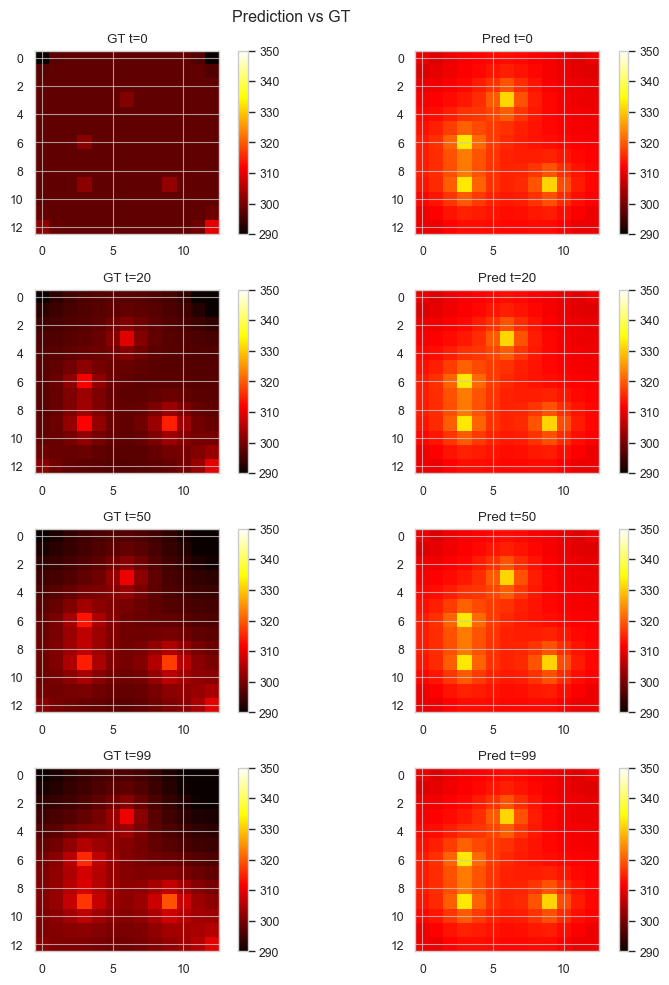

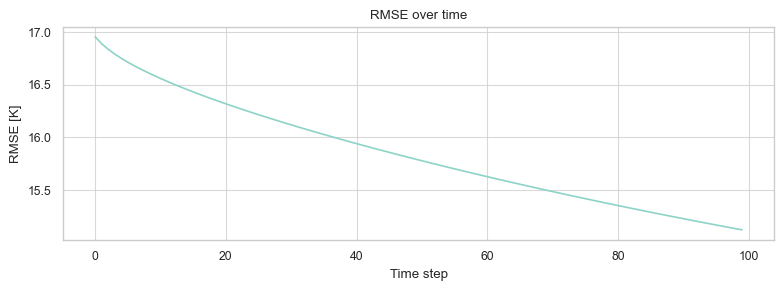

RMSE total: 15.849155


In [155]:
y_pred, y_gt = evaluate_model_case(model, val_ds, idx=0, denorm_fn=pcb_base.denormalize_output)
plot_case_comparison(y_pred, y_gt, steps=[0, 20, 50, 99])
rmse = compute_rmse_per_frame(y_pred, y_gt)
plot_rmse_over_time(rmse)
print("RMSE total:", rmse.mean())


In [156]:
def compute_rmse_per_frame(y_pred, y_gt):
    assert y_pred.shape == y_gt.shape, "Mismatch in shape"
    mse = ((y_pred - y_gt) ** 2).reshape(y_gt.shape[0], -1).mean(dim=1)
    return torch.sqrt(mse).cpu().numpy()


## 5 · Análisis de resultados

In [157]:
sys.path.append('../scripts')

if IN_COLAB:
  sys.path.append("/content/drive/MyDrive/ia_thermal_colab/ia_thermal/scripts")

from PCB_solver_tr import PCB_case_2

Condiciones de contorno elegidas (arbitrarias)

In [158]:
Q_heaters = np.array([1.0, 1.0, 1.0, 1.0])
T_interfaces = np.array([250.0, 250.0, 250.0, 250.0])
T_env = 250.0
time_sim = time_steps - 1

id_heaters = [(6,3), (3,6), (9,3), (9,9)]

Generación de los resultados analíticos

In [159]:
T_true, _, _, _ = PCB_case_2(solver = 'transient', display=False, time = time_sim, dt = 1, Q_heaters = Q_heaters, T_interfaces = T_interfaces, Tenv = T_env) # heaters in default position
T_true = T_true.reshape(T_true.shape[0], 13, 13) # reshaping the data grid-shape

### 🔁 predict_full_sequence(..., include T₀)

Versión de la predicción multistep que incluye explícitamente el estado inicial `T₀` en la secuencia de salida.

- Devuelve un tensor `(T, 13, 13)` donde `T = time_steps`.
- El primer frame `T[0]` es exactamente el estado inicial.
- Los siguientes se obtienen por acumulación: `T[t] = T₀ + ΣΔT`.

Esto permite comparar directamente con el ground truth completo.


In [160]:
def predict_full_sequence(model, pcb_dataset,
                          Q_heaters, T_interfaces, T_env,
                          T0_K=None, time_steps=100, device='cuda'):
    """
    Predice toda la secuencia de temperaturas, incluyendo el instante inicial (T₀).

    Salida: tensor (time_steps, 13, 13) en Kelvin
    """
    model.eval()
    device = torch.device(device)

    # --- T₀ en Kelvin ---
    if T0_K is None:
        T0_K = np.full((13, 13), 298.0, dtype=np.float32)
    T0 = torch.tensor(T0_K, dtype=torch.float32, device=device)

    mu = pcb_dataset.T_outputs_mean.to(device)
    sigma = pcb_dataset.T_outputs_std.to(device)
    T0_norm = (T0 - mu) / sigma

    # --- Condiciones de contorno ---
    Q = torch.tensor(Q_heaters, dtype=torch.float32, device=device)
    T_int = torch.tensor(T_interfaces, dtype=torch.float32, device=device)
    T_env = torch.tensor(T_env, dtype=torch.float32, device=device)

    Q_norm = (Q - pcb_dataset.Q_heaters_mean.to(device)) / pcb_dataset.Q_heaters_std.to(device)
    T_int_norm = (T_int - pcb_dataset.T_interfaces_mean.to(device)) / pcb_dataset.T_interfaces_std.to(device)
    T_env_norm = (T_env - pcb_dataset.T_env_mean.to(device)) / pcb_dataset.T_env_std.to(device)

    # --- Mapas espaciales ---
    Q_map = torch.zeros((13, 13), device=device)
    T_map = torch.zeros((13, 13), device=device)
    T_env_map = torch.full((13, 13), T_env_norm.item(), device=device)

    T_map[0, 0] = T_int_norm[0]
    T_map[0, -1] = T_int_norm[1]
    T_map[-1, -1] = T_int_norm[2]
    T_map[-1, 0] = T_int_norm[3]

    Q_map[6, 3] = Q_norm[0]
    Q_map[3, 6] = Q_norm[1]
    Q_map[9, 3] = Q_norm[2]
    Q_map[9, 9] = Q_norm[3]

    # --- Tensor de entrada ---
    x = torch.stack([
        T0_norm,
        (T_map != 0).float(), T_map,
        (Q_map != 0).float(), Q_map,
        T_env_map
    ], dim=0).unsqueeze(0).to(device)  # (1,6,13,13)

    # --- Predicción ---
    rollout = torch.zeros((time_steps, 13, 13), dtype=torch.float32, device=device)
    # print(rollout.shape)
    rollout[0] = T0_norm  # T₀ normalizado
    T_pred_norm = model(x)  # (1, T, 13, 13)
    T_pred_norm = T_pred_norm.squeeze(0).squeeze(0)  # (T, 13, 13)
    # print("T_pred_norm shape:", T_pred_norm.shape)
    rollout[1:] = T_pred_norm # Guardar predicciones desde t=1
    rollout = rollout * sigma + mu  # Desnormalizar

    return rollout.cpu()


Generación de la predicción de la red (rollout)

In [161]:
T_pred = predict_full_sequence(
    model, pcb_dataset=pcb_base,
    Q_heaters=[2.5, 1.0, 2.0, 0.5],
    T_interfaces=[310, 305, 300, 315],
    T_env=298.0,
    T0_K=None, time_steps=time_steps
)

T_pred = T_pred.detach().cpu().numpy() # pasamos a numpy para graficar

Representación de la evolución en nodos concretos

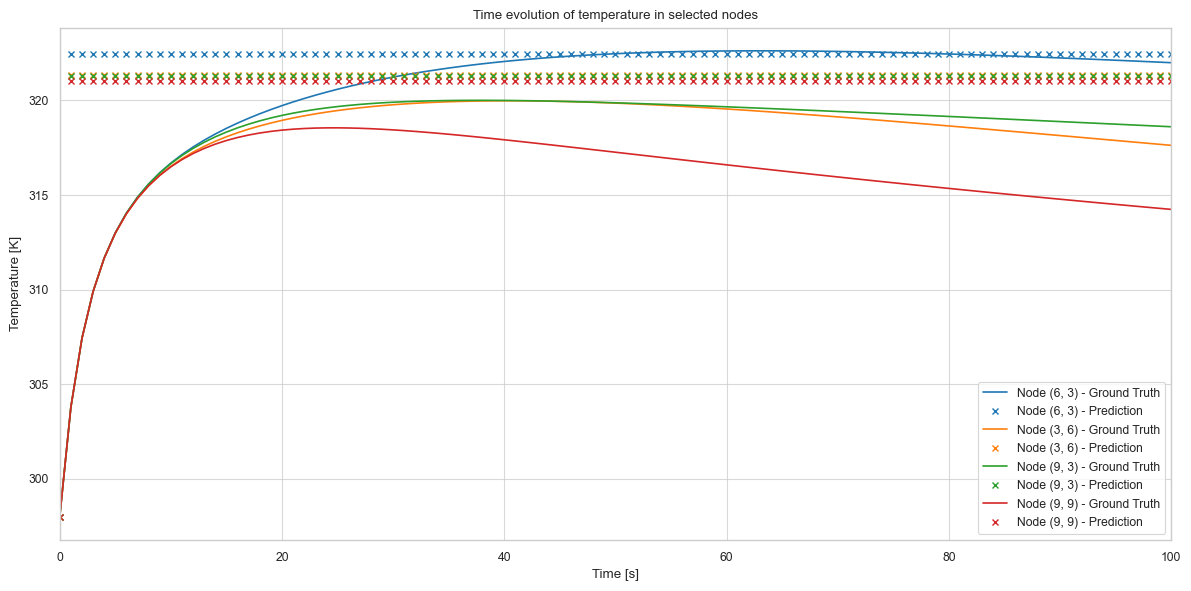

In [162]:
plot_nodes_evolution(T_pred, T_true, id_heaters, together=True)

Cuanto quedan dentro los nodos del umbral

In [163]:
umbral = 5

acierto = porcentaje_error_bajo_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de predicciones con error < {umbral:.1f} K: {acierto:.2f}%")

porcentaje, _, _ = nodos_siempre_dentro_umbral(T_true, T_pred, umbral=umbral)
print(f"Porcentaje de nodos buenos enm toda la simulación: {porcentaje:.2f}%")

Porcentaje de predicciones con error < 5.0 K: 2.90%
Porcentaje de nodos buenos enm toda la simulación: 0.00%


Representación de error acumulado

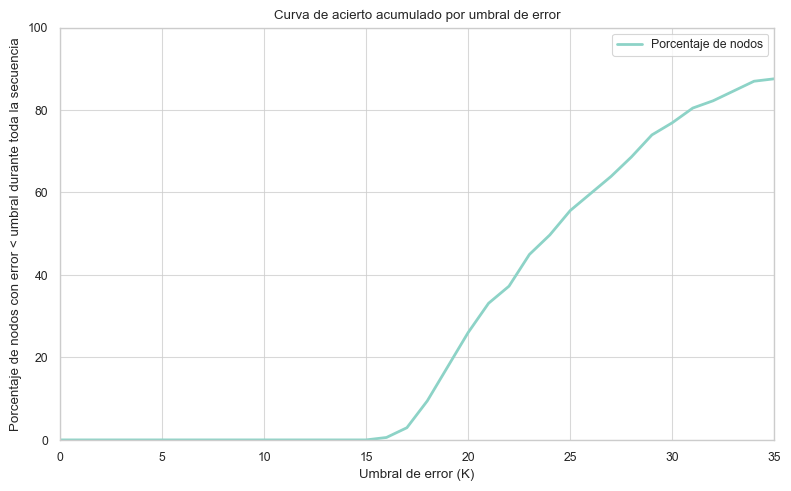

In [164]:
umbrales = np.linspace(0, 35, 36)
porcentajes = porcentaje_nodos_siempre_dentro_por_umbral(T_true, T_pred, umbrales)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(umbrales, porcentajes, label="Porcentaje de nodos", linewidth=2)
plt.xlabel("Umbral de error (K)")
plt.ylabel("Porcentaje de nodos con error < umbral durante toda la secuencia")
plt.title("Curva de acierto acumulado por umbral de error")
plt.grid(True)
plt.ylim(0, 100)
plt.xlim(0, umbrales[-1])
plt.legend()
plt.tight_layout()
plt.show()

Error por frame

In [165]:
def compute_temporal_errors(pred, gt, name="Model"):
    """
    Calcula RMSE y MAE por frame entre dos arrays NumPy.
    
    Parámetros:
    - pred: array de forma (T, H, W)
    - gt: array de forma (T, H, W)
    """
    pred = np.asarray(pred, dtype=np.float32)
    gt   = np.asarray(gt, dtype=np.float32)

    assert pred.shape == gt.shape, "❌ Dimensiones no coinciden"

    T = pred.shape[0]
    diff = pred - gt

    mse_per_frame = np.mean(diff ** 2, axis=(1, 2))  # (T,)
    mae_per_frame = np.mean(np.abs(diff), axis=(1, 2))

    rmse = np.sqrt(mse_per_frame)
    mae  = mae_per_frame
    t    = np.arange(T)

    plt.figure(figsize=(10, 4))
    plt.plot(t, rmse, label="RMSE [K]", color='orange')
    plt.plot(t, mae,  label="MAE  [K]", color='blue')
    plt.xlabel("Time step")
    plt.ylabel("Error [K]")
    plt.title(f"Per-frame error over time — {name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return rmse, mae

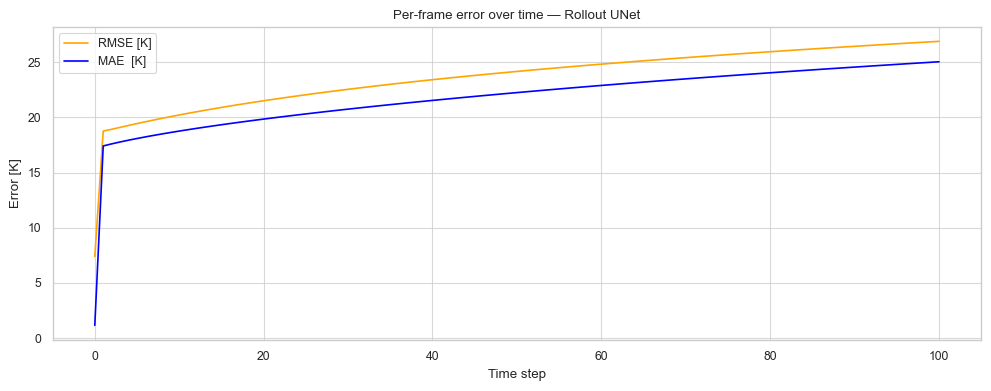

In [166]:
_, _ = compute_temporal_errors(T_pred, T_true, name="Rollout UNet")

Comparación de la evolución de las placas

In [167]:
ani = generar_gif_pcb_comparacion(T_pred, T_true, guardar_en_figures=True)

# from IPython.display import HTML
# HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook

Guardando gif en: c:\Users\ismael.gallo\Desktop\ia_thermal\ismaelgallo\figures\comparison_evolution.gif
Gif guardado.


GIF de evolución del error

In [168]:
ani = generar_gif_error_evolucion(T_pred, T_true, guardar_en_figures=True)

from IPython.display import HTML
HTML(ani.to_jshtml()) # Mostrar el GIF en Jupyter Notebook